In [86]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [87]:
df = pd.read_csv("features/mm_all.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['Mg', 'Na', 'Cu', 'Ca', 'Li', 'Al', 'Ni', 'Mn'], dtype=object)

### Size Modification and adding parameters to Data Frame

In [88]:
# df = df.iloc[:-1, :]
df

,Mol,Pol,Rad,CN,Ion,EN
0,Mg,71.20,160,8,7.646,1.31
1,Na,162.70,157,8,5.139,0.93
2,Cu,46.50,128,12,7.726,1.91
3,Ca,160.80,200,8,6.113,1.00
4,Li,164.11,182,8,5.392,0.98
5,Al,57.80,184,12,5.986,1.61
6,Ni,49.00,163,12,7.640,1.91
7,Mn,68.00,197,8,7.434,1.55


In [89]:

%store -r res
res 

# res = res[:-1]

[17.144355598718082,
 25.027177715806825,
 5.118879491233692,
 22.792844836933817,
 25.719392847659723,
 2.9222363463284893,
 10.553895436793855,
 15.857470042410599]

In [90]:
## always inverse of EN_A
# res = df['EA_A']/np.array(res)

## always inverse of delta EN

## always inverse of pol_A ( anion polarisation)

## remove df['EA_A'] from the dataframe
# df = df.drop(columns=['EA_A'])

res

[17.144355598718082,
 25.027177715806825,
 5.118879491233692,
 22.792844836933817,
 25.719392847659723,
 2.9222363463284893,
 10.553895436793855,
 15.857470042410599]

In [91]:
df = df.iloc[:,1:]


## always inverse of EN_A

# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']


# df['Sum_ion'] = df['Ion_C'] + df['Ion_A']
# df['Abs_diff_ion'] = abs(df['Ion_C'] - df['Ion_A'])




# # Adding sqrt values for each column
for col in df.columns:
    # Make sure the column is numeric before applying sqrt
    if pd.api.types.is_numeric_dtype(df[col]):
        df[f'{col}_sqrt'] = np.sqrt(abs(df[col]))
        df[f'{col}_squared'] = np.square(df[col])


df['cal'] = 1/df['pol_squared']
df['cal'] = df['cal']/df['pol_A_squared']

df.

# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']
df.shape

(8, 15)

### making the combinations

In [92]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [93]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [94]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


In [95]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:,1:].columns)
    all_expressions = generate_combinations_df(df.iloc[:, 1:], param_names)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_25324\3972913922.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


KeyboardInterrupt: 

In [79]:
expressions.head()

,Expression,Value
0,Rad,0 160 1 157 2 128 3 200 4 182 5...
1,CN,0 8 1 8 2 12 3 8 4 8 5 1...
2,Ion,0 7.646 1 5.139 2 7.726 3 6.113 4 ...
3,EN,0 1.31 1 0.93 2 1.91 3 1.00 4 0...
4,Pol_squared,0 5069.4400 1 26471.2900 2 2162.250...


### Addition results to the combinations

In [80]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [ ]:

correlation = values.corr()

correlation.shape

(19683, 19683)

In [82]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                             1.000000
Pol_squared^(-1) * Ion_squared^(-1)                                                             0.980374
CN * EN * Ion^(-1) * Pol_squared^(-1) * CN_squared^(-1) * Ion_squared^(-1)                      0.979932
CN * EN_squared * Ion^(-1) * EN^(-1) * Pol_squared^(-1) * CN_squared^(-1) * Ion_squared^(-1)    0.979932
EN_squared * CN^(-1) * Ion^(-1) * EN^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                 0.979932
EN * CN^(-1) * Ion^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                                   0.979932
EN^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                                                   0.973103
EN * Pol_squared^(-1) * Ion_squared^(-1) * EN_squared^(-1)                                      0.973103
CN_squared * CN^(-1) * Ion^(-1) * Pol_squared^(-1) * EN_squared^(-1)                            0.972296
CN * Ion^(-1) * Pol_squared^(-1) * EN_squared^(-1)     

### Final Results

In [83]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index


res                                                                                             1.000000
Pol_squared^(-1) * Ion_squared^(-1)                                                             0.980374
CN * EN * Ion^(-1) * Pol_squared^(-1) * CN_squared^(-1) * Ion_squared^(-1)                      0.979932
CN * EN_squared * Ion^(-1) * EN^(-1) * Pol_squared^(-1) * CN_squared^(-1) * Ion_squared^(-1)    0.979932
EN_squared * CN^(-1) * Ion^(-1) * EN^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                 0.979932
EN * CN^(-1) * Ion^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                                   0.979932
EN^(-1) * Pol_squared^(-1) * Ion_squared^(-1)                                                   0.973103
EN * Pol_squared^(-1) * Ion_squared^(-1) * EN_squared^(-1)                                      0.973103
CN_squared * CN^(-1) * Ion^(-1) * Pol_squared^(-1) * EN_squared^(-1)                            0.972296
CN * Ion^(-1) * Pol_squared^(-1) * EN_squared^(-1)     

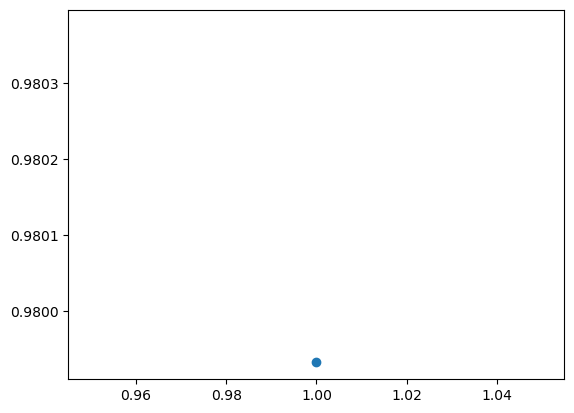

1.0


In [ ]:
import matplotlib.pyplot as plt

plt.scatter(results['res'],results[top_vars[3]])
plt.plot(results['res'],results[top_vars[0]])
plt.show()

values[top_vars[0]]


# param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']



# y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
# x = list(values['res'])[:4]+list(values['res'])[5:]

# plt.scatter(x,y)
# x

print(results['res'])

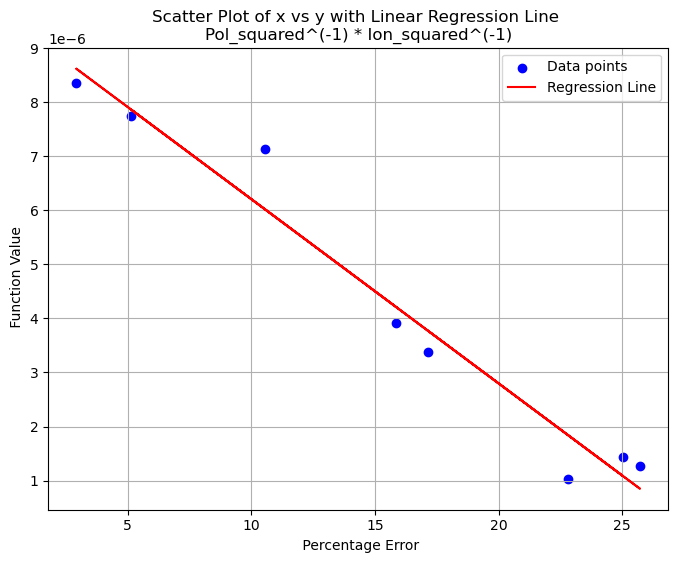

(0.9611329784871978, 3.1772017176500657e-13, 'y = -0.0000x + 0.0000')

In [ ]:
param = top_vars[0]

y = values[param]
x = values['res']

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming x and y are Pandas Series
# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Plot the data points and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line \n{param}')
plt.xlabel(' Percentage Error')
plt.ylabel(' Function Value')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSE
r_squared = r2_score(y, y_pred)
msd = mean_squared_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared, msd, equation


### Results 
1. CN_sqrt * Ion_sqrt * Pol_sqrt^(-1) * Rad_sqrt^(-1) 

2. Rad_sqrt * CN_sqrt * Ion_sqrt * Rad^(-1) * Pol_sqrt^(-1)


After adding alumninum relations changed 

1. Ion * Pol_sqrt * EN_sqrt * EN^(-1) * CN_sqrt^(-1)  